<a href="https://colab.research.google.com/github/brooke-huynh/avottraction/blob/main/avottraction_demoipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Welcome to the Avottraction Demo! 🍓💬

👋

In this Colab notebook, we'll explore a mini pipeline that **classifies text comments** into four categories:  
**Sexual, Flirty, Wordplay, and Funny** — all at the same time! 🧠✨

---

## ✅ What You’ll Learn / Review:

🔤 **Preprocessing** — cleaning and preparing text (emojis, contractions, stopwords)  
🧠 **Transformers & Tokenization** — breaking text into model-ready inputs  
🧪 **Training loop basics** — loss, steps, epochs, and batch sizes  
🎯 **Multi-label classification** — predicting more than one label per input  
🎚️ **Threshold tuning** — finding the best cutoff points for binary outputs  
📈 **Evaluation & Visualization** — interpreting F1, ROC AUC, and loss curves

---

## 🔍 What We'll Do:

- Clean and tokenize sample data  
- Train a 🤖 **DistilBERT** model on a small dataset  
- Log and visualize the training process  
- Experiment with predictions, metrics, and thresholds  
- Discuss ideas to extend or adapt the pipeline

💡 The goal isn't just to *run* a model — it's to **understand how it works!**

👇 Let’s get started!

# Notebook Setup

Cell 1: Install & import dependencies</summary>

In [ ]:
!pip uninstall -y transformers
!pip install git+https://github.com/huggingface/transformers.git


Found existing installation: transformers 4.52.0.dev0
Uninstalling transformers-4.52.0.dev0:
  Successfully uninstalled transformers-4.52.0.dev0
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-7vdl_iky
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-7vdl_iky
  Resolved https://github.com/huggingface/transformers.git to commit b6d65e40b256d98d9621707762b94bc8ad83b7a7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.52.0.dev0-py3-none-any.whl size=11455925 sha256=6357afe8990ec73f2df2df32a79df9d0beb366c782bc057bbc4ca5181265d3af
  Stored in directory: /tmp/pip-ephem-wheel-cache-vwoh8b3t/wheels/32/4b/78/f195c684dd3a9ed21f3b39fe8f85b48df7918581b6437be143
Successfully built transformers


In [ ]:
!pip install torch sklearn emoji nltk contractions

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import transformers
print(transformers.__version__)   # should be something like 4.x.dev
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from torch import sigmoid


4.52.0.dev0


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<details><summary> Why install transformers, emoji, contractions? </summary>
They provide the core model code, emoji‐to‐text conversion, and contraction expansion our preprocessing relies on. </details>

<details><summary> What happens if we skip NLTK downloads before import? </summary>
The stopword/lemmatizer calls will error because the required corpora aren’t present.

# Data Loading & Splits

Cell 2: Load your CSV from Drive or upload</summary>

1.   Follow this link for the dataset (https://drive.google.com/drive/folders/1RXE-6zdCMa66qisnR7I2btEK0idlr3Io?usp=sharing)

2.   Download it
3.   Go to Files -> Drag and Drop

<details>

In [ ]:
import os
print(os.listdir('/content'))

['.config', 'avottraction_dataset.csv', 'preprocessing.py', '__pycache__', 'sample_data']


In [ ]:
df = pd.read_csv('/content/avottraction_dataset.csv')
df.head()

,Text,Sexual,Flirty,Wordplay,Funny
0,"Ya know, just angsty songs about how my hometo...",0,0,0,0
1,Not that I relate to any of that at all…,0,0,0,1
2,And then you get cool guitar riffs that sound ...,0,0,0,1
3,All in a weirdly spoken word whine that makes ...,0,0,0,1
4,"Forget 12 days of Christmas, how about 12 mont...",0,1,1,0


Cell 3: Train / Validation / Test split</summary>

In [ ]:
# texts and multi-label targets
X = df["Text"].fillna("").tolist()
y = df[["Sexual","Flirty","Wordplay","Funny"]].values

# 15% hold-out test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# ~15% of full data → validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.176647, random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 6984, Val: 1499, Test: 1498


</details> <details> <summary>Why separate train/val/test?</summary>
To train on one set, tune hyperparameters on another, and get an unbiased final performance estimate.

</details> <details> <summary>Why 70/15/15 and random_state=42?</summary>
It’s a common balance; the fixed seed ensures reproducible splits for everyone.

# Preprocessing

Cell 4: Define & apply your TextProcessor</summary>

In [ ]:
from preprocessing import TextProcessor, preprocess_text

processor      = TextProcessor(preprocess_func=preprocess_text)
X_train_clean  = processor.transform(pd.Series(X_train)).tolist()
X_val_clean    = processor.transform(pd.Series(X_val)).tolist()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Tip: you can print a few examples to see how the cleaner works.

In [ ]:
preprocess_text("hello")

<details> <summary>Why lowercase, strip URLs/emails, demojize?</summary>
To reduce vocabulary size and normalize text for the model.</details>

<details> <summary>How do stop‐word removal and lemmatization help?</summary>
They remove filler tokens and collapse word forms, focusing learning on meaningful roots.

# Tokenization & Dataset

Cell 5: Tokenize with DistilBERT</summary>

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(X_train_clean, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(X_val_clean,   truncation=True, padding=True, max_length=128)


Cell 6: Wrap into a PyTorch Dataset</summary>

In [ ]:
class AvoDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.astype(float)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_ds = AvoDataset(train_encodings, y_train)
val_ds   = AvoDataset(val_encodings,   y_val)


<details> <summary>What if the tokenizer sees an unknown word?</summary>
It breaks it into subword pieces or uses an [UNK] token. </details>

<details> <summary>Why max_length=128 and what if text is longer?</summary>
It caps sequence size for memory reasons; longer text is truncated to fit.

# Model & Trainer
Cell 7: Load model & send to GPU/CPU</summary>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=4,
    problem_type="multi_label_classification"
).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cell 8: Define compute_metrics</summary>



In [ ]:
best_thresholds = [0.5]*4

def compute_metrics(pred):
    logits = torch.tensor(pred.predictions)
    probs  = sigmoid(logits).cpu().numpy()
    y_preds = np.stack([
        (probs[:,i] >= best_thresholds[i]).astype(int)
        for i in range(probs.shape[1])
    ], axis=1)
    y_true = pred.label_ids
    return {
        "accuracy":  (y_preds==y_true).all(axis=1).mean(),
        "f1_macro":  f1_score(y_true, y_preds, average="macro"),
        "roc_auc":   roc_auc_score(y_true, probs)
    }


<details><summary>What does problem_type="multi_label_classification" do?</summary>
It switches the loss to BCEWithLogitsLoss so each label is predicted independently.</details>
<details><summary>Why use DistilBERT instead of full BERT?</summary>
It’s smaller and faster, trading a bit of accuracy for speed.


# TrainingArguments & Training Loop
Cell 9: TrainingArguments & Trainer</summary>

In [ ]:
# args = TrainingArguments(
#     output_dir='results',
#     num_train_epochs=5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=64,
#     evaluation_strategy='epoch',
#     save_strategy='epoch',
#     logging_dir='./logs',
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model='f1_macro',
#     learning_rate=2e-5,
#     weight_decay=0.01,
# )

# 1) subsample
from torch.utils.data import Subset
small_train = Subset(train_ds, range(200))
small_val   = Subset(val_ds,   range(50))



args = TrainingArguments(
    output_dir="demo",
    per_device_train_batch_size=32,
    num_train_epochs=1,   # just 1 pass (and we'll cut it at 20 steps anyway)
    max_steps=20,
    do_train=True,
    do_eval=False,        # skip mid‐training eval
    logging_steps=1,
    save_steps=20,        # only save at the end
)

trainer = Trainer(
    model=model,
    args=args,
    # train_dataset=train_ds,
    # eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    train_dataset=small_train,
    eval_dataset=small_val,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()


Step,Training Loss
1,0.295900
2,0.251900
3,0.249000
4,0.282700
5,0.261300
6,0.303900
7,0.241700
8,0.291000
9,0.247900
10,0.212000


TrainOutput(global_step=20, training_loss=0.24605508745735277, metrics={'train_runtime': 496.6632, 'train_samples_per_second': 1.289, 'train_steps_per_second': 0.04, 'total_flos': 19605874262016.0, 'train_loss': 0.24605508745735277, 'epoch': 2.857142857142857})

<details><summary>How do batch size and learning rate interact?</summary>
Larger batches can tolerate a higher learning rate; smaller batches often need a lower one.</details>
<details><summary>What’s the trade-off of frequent eval/checkpoint vs. speed?</summary>
More frequent means finer monitoring but slower overall training.

# Threshold Optimization
Cell 10: Find best per-label thresholds</summary>

In [ ]:
val_logits = trainer.predict(val_ds).predictions
val_probs  = sigmoid(torch.tensor(val_logits)).numpy()

best_thresholds = []
for i in range(y_val.shape[1]):
    best_f1, best_t = 0, 0.1
    for t in np.arange(0.1, 0.7, 0.05):
        preds = (val_probs[:,i] >= t).astype(int)
        f1 = f1_score(y_val[:,i], preds)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    best_thresholds.append(best_t)

print("Best thresholds:", best_thresholds)


Best thresholds: [np.float64(0.1), np.float64(0.20000000000000004), np.float64(0.25000000000000006), np.float64(0.1)]


<details><summary>Why not threshold all labels at 0.5?</summary>
Different labels have different score distributions; tuning maximizes F1 for each.</details>

<details><summary>How do precision and recall shift with threshold?</summary>
Higher threshold → higher precision, lower recall; lower threshold flips that.

# Evaluation & Interaction
Cell 11: Evaluate on the test set</summary>

In [ ]:
# Clean the raw X_test texts
X_test_clean = processor.transform(pd.Series(X_test)).tolist()

# Tokenize
test_encodings = tokenizer(
    X_test_clean,
    truncation=True,
    padding=True,
    max_length=128
)
test_ds = AvoDataset(test_encodings, y_test)

# Evaluate
test_metrics = trainer.evaluate(test_ds)
print("Test set performance:", test_metrics)

Test set performance: {'eval_loss': 0.2810776269116821, 'eval_accuracy': 0.6755674232309746, 'eval_f1_macro': 0.5091204485033162, 'eval_roc_auc': 0.8226520150426914, 'eval_runtime': 402.1702, 'eval_samples_per_second': 3.725, 'eval_steps_per_second': 0.467, 'epoch': 2.857142857142857}


Cell 12: Interactive threshold tuning</summary>

In [ ]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.0 MB/s eta 0:00:00


In [ ]:

from ipywidgets import FloatSlider, interact

def viz_threshold(label_idx=0, thresh=0.5):
    preds = (val_probs[:,label_idx] >= thresh).astype(int)
    print(f"Label {label_idx} — F1: {f1_score(y_val[:,label_idx], preds):.3f}")

interact(
    viz_threshold,
    label_idx=(0,3,1),
    thresh=FloatSlider(min=0.1, max=0.7, step=0.05, value=0.5)
)


interactive(children=(IntSlider(value=0, description='label_idx', max=3), FloatSlider(value=0.5, description='…

<function __main__.viz_threshold(label_idx=0, thresh=0.5)>

<details><summary>Why use macro-F1 over accuracy?</summary>
Macro-F1 weighs each label equally, guarding against class‐imbalance distortions.</details>

<details><summary> What if AUC is ~0.5 for a label?</summary>
The model has no discriminatory power—predictions are like random guessing.

# Visualization

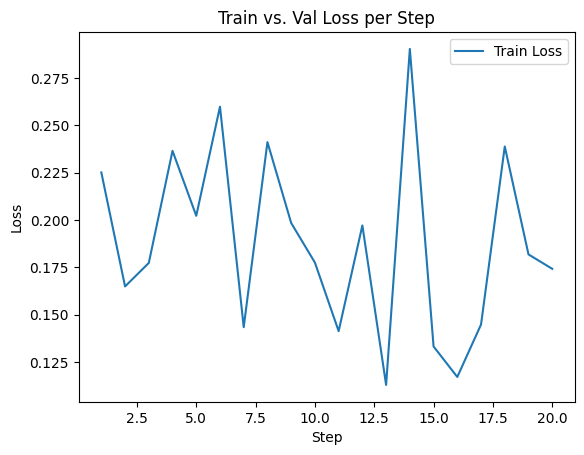

In [ ]:
import matplotlib.pyplot as plt

# Extract loss per step
train_steps, train_losses = [], []
eval_steps,  eval_losses  = [], []

for entry in trainer.state.log_history:
    if 'loss' in entry and 'eval_loss' not in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

# Plot by step (not epoch)
plt.figure()
plt.plot(train_steps, train_losses, label='Train Loss')

plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Train vs. Val Loss per Step')
plt.legend()
plt.show()


"We're seeing that the model's loss fluctuates between batches, which is expected for a small-scale demo like this. We do get a slight downward trend, which hints at learning. In real training, we'd smooth this with more steps or larger batches — but for now, it confirms that our training loop is working correctly."

## 🌟 What Does "Good" Look Like? (A Peek Ahead)

Once you've got the hang of the pipeline and start experimenting with things like learning rate, batch size, or threshold tuning — **you can absolutely get strong results!**

In a fully tuned version of this same model, trained on the full dataset with carefully chosen hyperparameters, here's what we were able to achieve:

### 📊 Evaluation Metrics
- **Eval Loss:** `0.1905` – low error on unseen data
- **Accuracy (Subset):** ~79.5% ✅
- **Macro F1-score:** ~73.2% – balanced performance across labels  
- **Per-label F1-scores:**
  - Label 1: 66.15%
  - Label 2: 86.42%
  - Label 3: 76.51%
  - Label 4: 63.82%
- **Per-label Accuracy:** ~90.4%–97.1%
- **ROC-AUC:** ~0.943 🎯 – shows the model separates classes very well

### ⚙️ Training Metrics
- **Final Train Loss:** ~0.1469 (after 5 full epochs)
- **Runtime:** Efficient training and evaluation times

### 🎚️ Threshold Optimization
Each label gets its own threshold:
```python
[0.3, 0.55, 0.6, 0.3]
```

## 🛠️ Next Steps & Customization

Now that you've seen the pipeline in action, here are some ideas for where to go next — this is where the real creativity starts! 🎨

### 🔧 Hyperparameter Tuning
Try experimenting with:
- `learning_rate`: Try slightly higher or lower values (e.g. `3e-5`, `1e-5`)
- `batch_size`: Larger batches may stabilize training; smaller batches may generalize better
- `num_train_epochs`: 3–5 is usually a good sweet spot

### 🧪 Data Augmentation & Preprocessing
- Add new rules to `preprocess_text` (e.g. smarter emoji handling or negation detection)
- Explore synonym replacement or dropout-based augmentation to increase robustness

### 📊 Visualization
- Plot **loss curves** to monitor training/validation performance over time
- Plot **ROC curves** for each label to understand the model's discriminative ability
- Try using a **confusion matrix** if you explore single-label versions later

### 🔍 New Predictions (Try It Live!)
Run the model on custom inputs:


``` python
new_texts = ["Are you a magician? Because every time I look at you, everyone else disappears."]
enc = tokenizer(new_texts, return_tensors="pt", truncation=True, padding=True).to(model.device)
with torch.no_grad():
    logits = model(**enc).logits
probs = torch.sigmoid(logits).cpu().numpy()
print("Predicted probabilities:", probs)
```

## ✅ Your Model-Building Checklist

You're now ready to build your own classifier using your custom scraped dataset! Here's a step-by-step guide to make sure your pipeline works end-to-end:

---

### 🧼 1. Preprocessing Your Own Data
- [ ] Load your custom dataset into a DataFrame (e.g., `pd.read_csv()` or `json.load()`)
- [ ] Identify your input text column (e.g., "content", "comment", etc.)
- [ ] Map your labels to 0/1 format for multi-label classification
- [ ] Clean your text using or adapting the `preprocess_text()` function
- [ ] Optional: add emoji handling, custom token filters, or domain-specific rules

---

### 🔄 2. Tokenization
- [ ] Use `DistilBertTokenizerFast` to tokenize your preprocessed text
- [ ] Truncate and pad to a reasonable `max_length` (64 or 128)

---

### 📦 3. Dataset Wrapping
- [ ] Create a `torch.utils.data.Dataset` class if using raw tensors
- [ ] Double-check label dimensions match model expectations

---

### 🧠 4. Model Setup
- [ ] Load `DistilBertForSequenceClassification` with `num_labels=N`
- [ ] Use `problem_type="multi_label_classification"` for independent label heads

---

### ⚙️ 5. Training
- [ ] Define sensible `TrainingArguments` (batch size, learning rate, etc.)
- [ ] Split your dataset: train/val/test
- [ ] Train with `Trainer(train_dataset=..., eval_dataset=...)`
- [ ] (Optional) Use `EarlyStoppingCallback` if running for longer

---

### 🎯 6. Evaluation & Thresholds
- [ ] Predict on validation data and compute metrics (accuracy, F1, ROC-AUC)
- [ ] Tune per-label thresholds using validation results
- [ ] Evaluate final model on test set

---

### 📊 7. Visualizations
- [ ] Plot **training vs. validation loss** over time
- [ ] Plot **ROC curves** for each label
- [ ] Visualize confusion matrix (if switching to single-label later)

---

### 🚀 8. Deploy/Test Your Model
- [ ] Write a function to take new text and output predicted labels
- [ ] Test with new data (or live inputs!)
- [ ] Optional: wrap your model with a simple UI or API

---

> ✅ Once you've completed this checklist, you'll have a fully custom, fine-tuned, multi-label classifier trained on your own dataset.